# Outliers and Their Influence on the Final Model

## Table of Contents:

1. Read point data and take 10% of it as a sample for the further analysis (dataset A),
2. Check if outliers are present in a data and create additional dataset without outliers (dataset B),
3. Create the Variogram Point Cloud model for the datasets A and B,
4. Remove outliers from the datasets A and B,
5. Create four Ordinary Kriging models and compare their performance.

## Level: Intermediate

## Changelog

| Date | Change description                                                                                                                                                     | Author |
|------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------|
| 2023-04-15 | Tutorial debugged and updated to the 0.4.1 version of the package                                                     | @SimonMolinsky |
| 2022-11-05 | Tutorial updated for the 0.3.5 version of the package | @SimonMolinsky |
| 2022-10-08 | The tutorial updated to the version 0.3.2 of the package                                                                                                               | @SimonMolinsky |
| 2022-08-27 | The tutorial updated to the version 0.3.0 of the package                                                                                                               | @SimonMolinsky |
| 2021-12-14 | Sill selection was upgraded: now optimal sill is derived from the grid search within `TheoreticalSemivariogram` class                                                  | @SimonMolinsky |
| 2021-12-13 | Changed behavior of `select_values_in_range()` function                                                                                                                | @SimonMolinsky |
| 2021-12-11 | Behavior of `prepare_kriging_data()` function has benn changed                                                                                                         | @SimonMolinsky |
| 2021-10-13 | Refactored TheoreticalSemivariogram (name change of class attribute) and refactored `calc_semivariance_from_pt_cloud()` function to protect calculations from `NaN's`. | @ethmtrgt & @SimonMolinsky |
| 2021-08-22 | Initial release                                                                                                                                                        | @SimonMolinsky |

## Introduction

Outliers may affect our analysis and the final interpolation results. In this tutorial, we learn about their influence on the final model and compare interpolation errors for different scenarios where data is cleaned differently.

We can remove too high or too low values at the preprocessing stage (check part 2 of the tutorial) or remove outliers directly from the variogram point cloud (part 4). Results from each type of preprocessing (and a raw dataset analysis) are different, and we will compare them.

We use:

- DEM data which is stored in a file `samples/point_data/txt/pl_dem_epsg2180.txt`.

## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyinterpolate import calc_point_to_point_distance, read_txt, kriging, TheoreticalVariogram, VariogramCloud

## 1) Read point data and divide it into training and test set

In [2]:
# Read data from file

dem = read_txt('samples/point_data/txt/pl_dem_epsg2180.txt')

In [3]:
# Divide data into training and test set

def create_train_test(data, training_fraction):
    idxs = np.arange(0, len(data))
    number_of_training_samples = int(len(data) * training_fraction)
    training_idxs = np.random.choice(idxs, size=number_of_training_samples, replace=False)
    test_idxs = [i for i in idxs if i not in training_idxs]
    training_set = data[training_idxs, :]
    test_set = data[test_idxs, :]
    
    return training_set, test_set

In [4]:
train, test = create_train_test(dem, 0.1)

In [5]:
train[:3]

array([[2.50526437e+05, 5.35859616e+05, 3.99433975e+01],
       [2.49072390e+05, 5.51296720e+05, 7.20873566e+01],
       [2.47840493e+05, 5.48684836e+05, 7.57771988e+01]])

## 2) Check outliers: analyze the distribution of the values

We will inspect all values in the `train` set to determine if our dataset contains outliers. In the beginning, we plot data distribution with the `violinplot`.

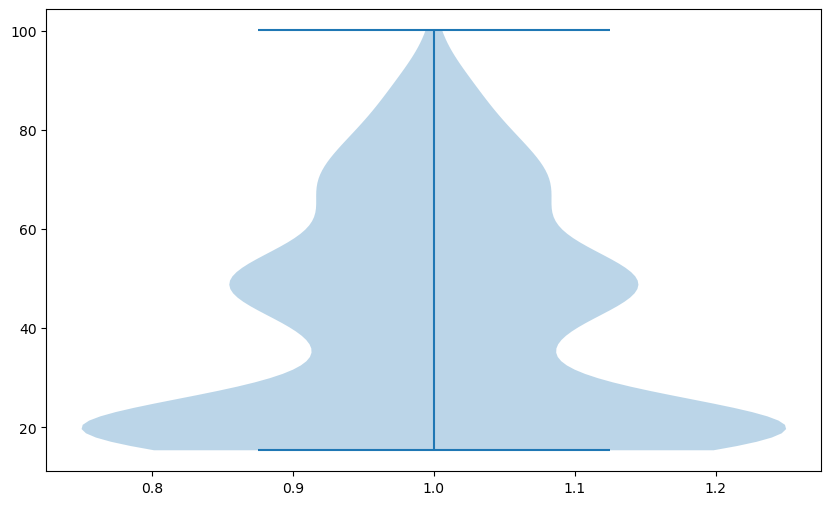

In [6]:
# Distribution plot

plt.figure(figsize=(10, 6))
plt.violinplot(train[:, -1])
plt.show()

> **NOTE:** Your plot may be different than the tutorial's. Why is that? Because we take a random sample of 10% of values, and after each iteration, the algorithm takes different points for the analysis.

**Clarification:**

Investigation of the plot tells us that our data is:

- grouped around the lowest values, and most of the values are below 50 meters,
- has (probably) three different distributions mixed, which can be a sign that the Digital Elevation Model covers three different types of elevation. One is grouped around 20 meters, the next around 50 meters, and the faintest is visible around 70 meters.

**Violinplot** is suitable for the distribution analysis. Especially if we are looking for complex patterns in the dataset, reading outliers from it may be challenging. We should change a plot type to understand if outliers exist in a dataset. The excellent choice is the `boxplot`:

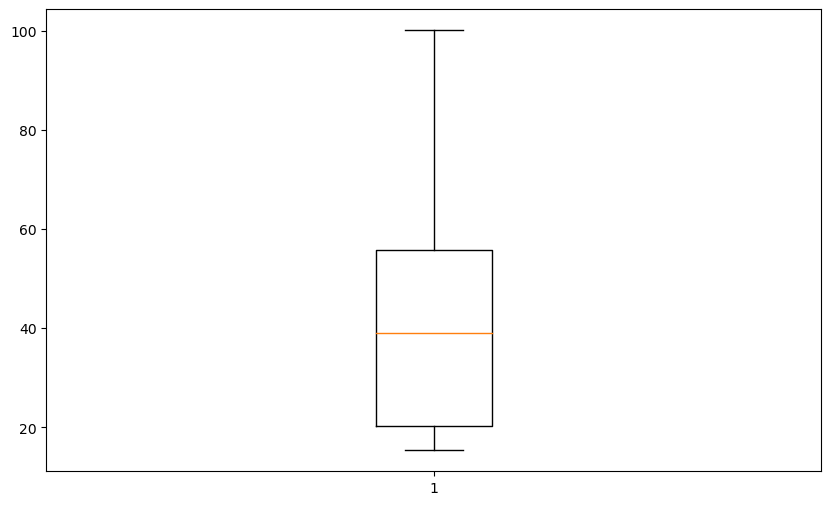

In [7]:
# Boxplot

plt.figure(figsize=(10, 6))
plt.boxplot(train[:, -1])
plt.show()

**Boxplot** is a unique and handy data visualization tool. Let's analyze this plot from the bottom up to the top.

> **NOTE:** Boxplot represents values sorted in ascending order and their statistical properties: quartiles, median, and outliers.

- The bottom whisker (horizontal line) represents the lower range of values in our dataset,
- The box lower line is the first quartile of data or, in other words, 25% of values of our dataset are below this point. We name it Q1.
- The middle line is the median of our dataset, and we name it Q2 or median.
- The upper line is the third quartile of a data or, in other words, 75% of values are below this point,
- The top whisker represents the upper range of values in our dataset. We name it Q3.
- Individual points (if they exist, then we see them as points below the bottom whisker or above the top whisker) are considered outliers. They could be outliers in the upper range as well as lower range of our data. The significant distance between Q1 and the bottom whisker or between Q3 and the top whisker indicates potential outliers. Points below or above this distance are treated as outliers. The outlier distance is calculated as the $weight * (Q3 - Q1)$ where we can set the `weight` manually, but other parameters are read directly from the data.

We use this knowledge to remove outliers from the dataset, assuming that _outliers are anomalies rather than unbiased readings_. We will perform the outlier removal from the data assuming that outliers are placed one standard deviation from Q1 (down) and Q3 (up).

In [8]:
# Create training set without outliers

q1 = np.quantile(train[:, -1], 0.25)
q3 = np.quantile(train[:, -1], 0.75)

top_limit = q3 + (q3 - q1)

train_without_outliers = train[train[:, -1] < top_limit]

In [9]:
print('Length of the full training set is {} records'.format(len(train)))
print('Length of the pre-processed training set is {} records'.format(len(train_without_outliers)))

Length of the full training set is 689 records
Length of the pre-processed training set is 684 records


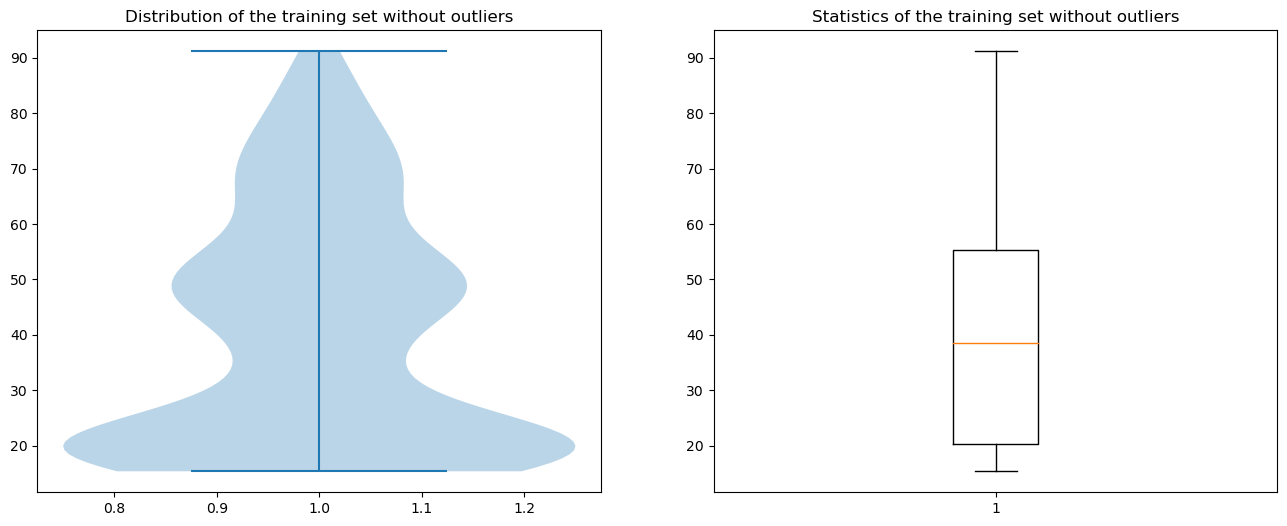

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax[0].violinplot(train_without_outliers[:, -1])
ax[0].set_title('Distribution of the training set without outliers')
ax[1].boxplot(train_without_outliers[:, -1])
ax[1].set_title('Statistics of the training set without outliers')
plt.show()

**Clarification**: We have cut some records from the baseline training dataset. The distribution plot (`violinplot`) has a shorter tail and ends more abruptly upwards. The `boxplot` of the new data doesn't have any outliers. The one crucial thing to notice is that the observations are still skewed, but this is not a problem for this concrete tutorial.

> **NOTE**: if you are eager to know how to deal with skewed datasets, we recommend the article [**Transforming Skewed Data**](https://anatomisebiostats.com/biostatistics-blog/transforming-skewed-data/).

## 3) Create the Variogram Point Cloud model for datasets A and B

Now we are going one step further, and we will transform both datasets with- and without- outliers and calculate variogram point clouds. Then we compare both clouds.

In [11]:
def get_variogram_point_cloud(dataset, max_range, number_of_lags=8):
    step_size = max_range / number_of_lags
    cloud = VariogramCloud(input_array=dataset, step_size=step_size, max_range=max_range, calculate_on_creation=True)
    return cloud

In [12]:
whole_distance = np.max(calc_point_to_point_distance(train[:, :-1]))

cloud_raw = get_variogram_point_cloud(train, whole_distance)
cloud_processed = get_variogram_point_cloud(train_without_outliers, whole_distance)

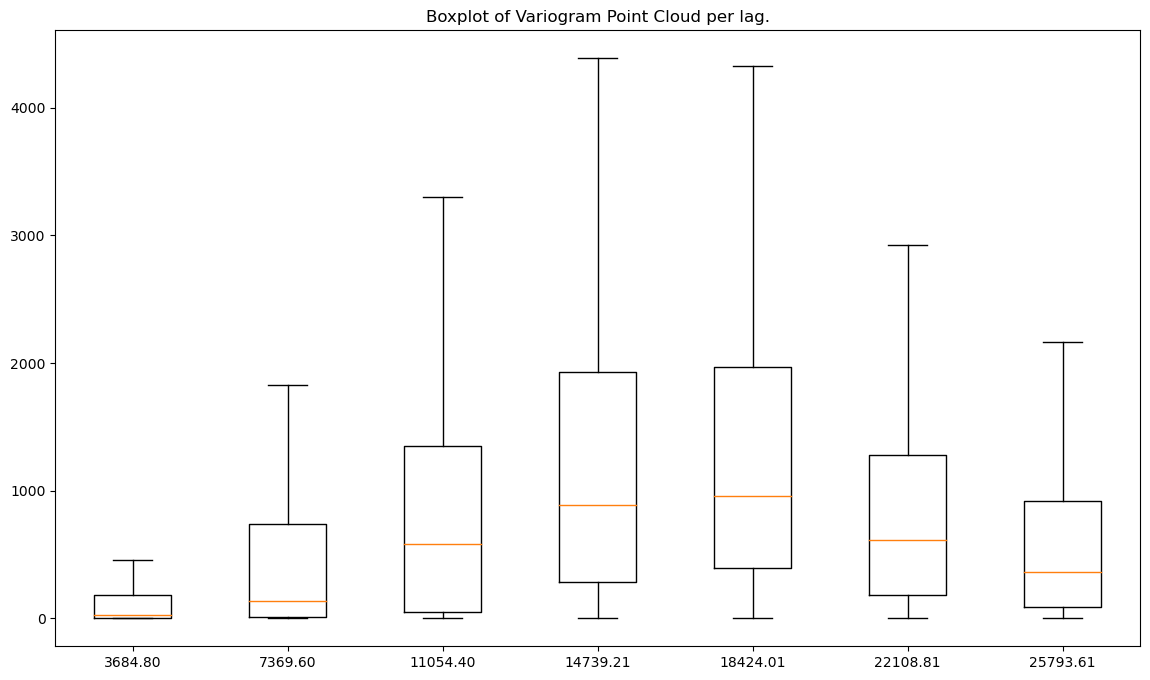

True

In [13]:
# Show variogram cloud: initial training dataset

cloud_raw.plot('box')

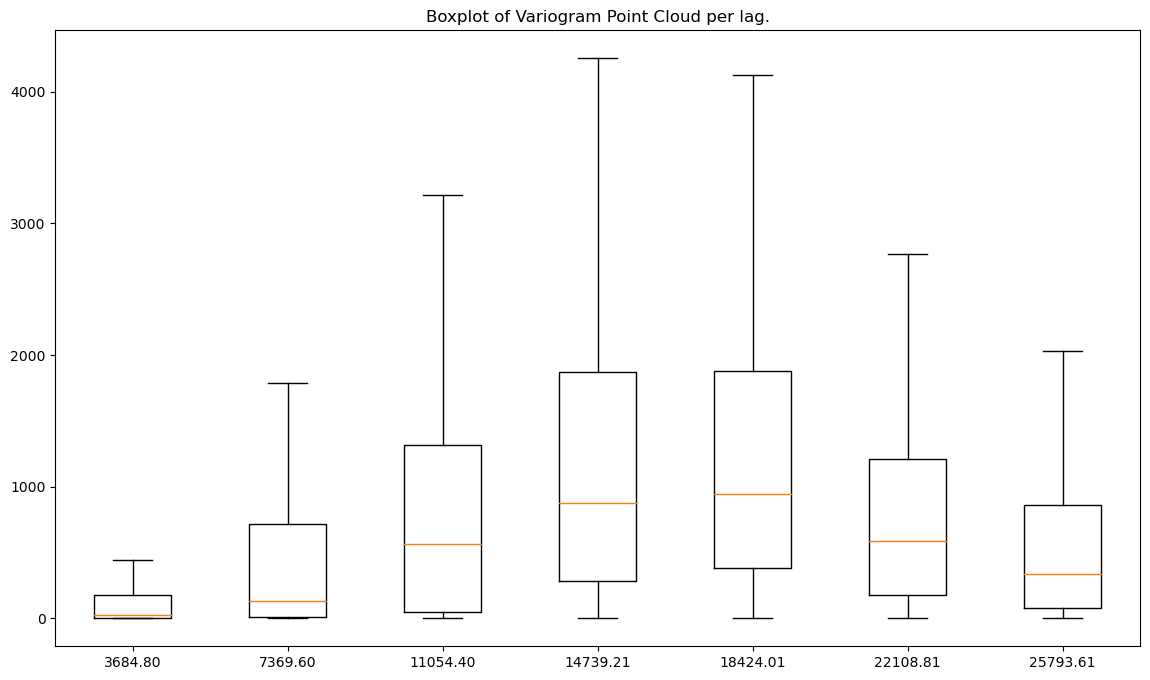

True

In [14]:
# Show variogram cloud: pre-processed training dataset

cloud_processed.plot('box')

**Clarification:** a quick look into the results shows that calculated semivariances are skewed into significant positive values for each lag, but most profoundly within middle lags (~15:21 km). The processed dataset has lower semivariances than the raw readings, and both variograms have a similar shape.

In the next cell, we will check a standard deviation of the per lag variances.

In [15]:
for k, v in cloud_raw.experimental_point_cloud.items():
    print('Lag {:.2f}'.format(k))
    
    v_raw = int(np.std(v))
    v_pro = int(np.std(cloud_processed.experimental_point_cloud[k]))
    v_smape = 100 * (np.abs(v_raw - v_pro) / (0.5 * (v_raw + v_pro)))
    
    print('Standard Deviation raw dataset:', v_raw)
    print('Standard Deviation processed dataset:', v_pro)
    print('Symmetric Mean Absolute Percentage Error of Variances: {:.2f}'.format(v_smape))
    print('')

Lag 3684.80
Standard Deviation raw dataset: 647
Standard Deviation processed dataset: 645
Symmetric Mean Absolute Percentage Error of Variances: 0.31

Lag 7369.60
Standard Deviation raw dataset: 1088
Standard Deviation processed dataset: 1039
Symmetric Mean Absolute Percentage Error of Variances: 4.61

Lag 11054.40
Standard Deviation raw dataset: 1257
Standard Deviation processed dataset: 1190
Symmetric Mean Absolute Percentage Error of Variances: 5.48

Lag 14739.21
Standard Deviation raw dataset: 1300
Standard Deviation processed dataset: 1224
Symmetric Mean Absolute Percentage Error of Variances: 6.02

Lag 18424.01
Standard Deviation raw dataset: 1215
Standard Deviation processed dataset: 1144
Symmetric Mean Absolute Percentage Error of Variances: 6.02

Lag 22108.81
Standard Deviation raw dataset: 907
Standard Deviation processed dataset: 880
Symmetric Mean Absolute Percentage Error of Variances: 3.02

Lag 25793.61
Standard Deviation raw dataset: 800
Standard Deviation processed data

**Clarification:** The differences (sMAPE) per lag vary greatly. We can see that the preprocessing of raw values introduces the information lost, and it is especially painful for the closest neighbors. It doesn't mean that the preprocessing of raw observations is not recommended, but it is a good idea to include the **spatial component** in the outliers' detection process.

Not everything is wrong. Data cleaning has lowered the semivariances dispersion for the middle lags (where we have the largest number of point pairs for the analysis).

At this point, we cannot judge which dataset is better for the modeling. Instead, we will remove outliers from both **variograms** (instead of the **raw data**).

## 4) Remove outliers from the variograms

In this step, we will use **pyinterpolate's** function `remove_outliers()` to build two additional variogram point clouds from the raw and processed datasets. We delete the top part outliers of the **semivariance values** rather than the raw readings.

In [16]:
raw_without_outliers = cloud_raw.remove_outliers(method='zscore', z_lower_limit=-2, z_upper_limit=2, inplace=False)
prep_without_outliers = cloud_processed.remove_outliers(method='zscore', z_lower_limit=-2, z_upper_limit=2, inplace=False)

In [17]:
data_raw = [x for x in cloud_raw.experimental_point_cloud.values()]
data_raw_not_out = [x for x in raw_without_outliers.experimental_point_cloud.values()]
data_prep = [x for x in cloud_processed.experimental_point_cloud.values()]
data_prep_not_out = [x for x in prep_without_outliers.experimental_point_cloud.values()]

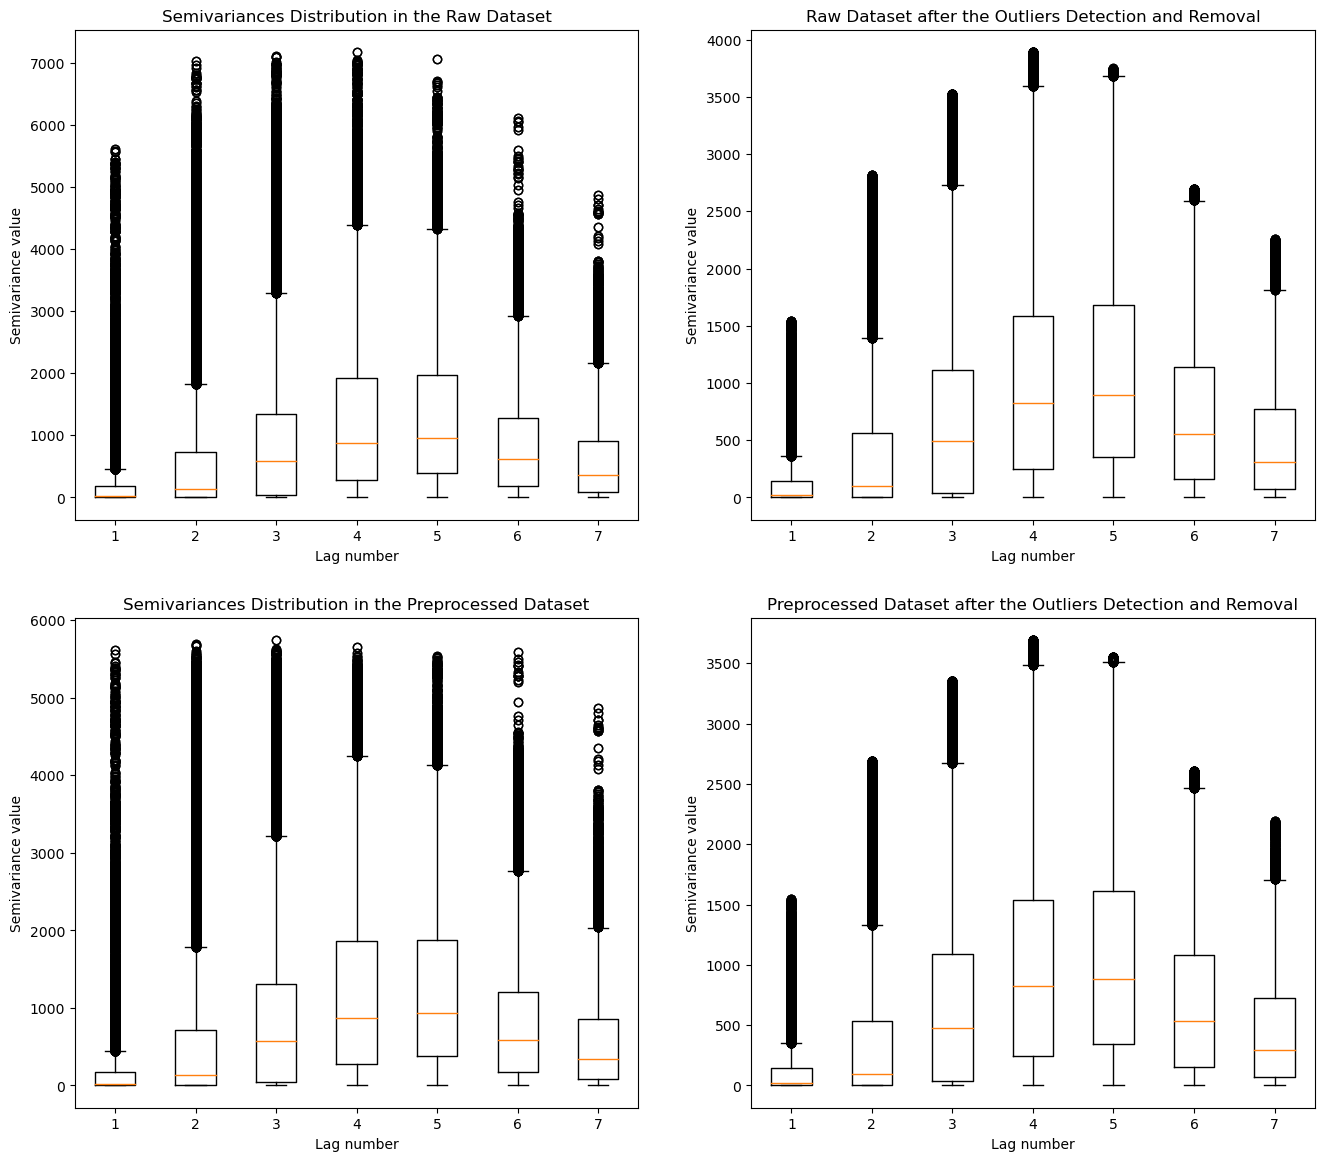

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 14))

ax[0, 0].boxplot(data_raw)
ax[0, 0].set_title('Semivariances Distribution in the Raw Dataset')
ax[0, 0].set_xlabel('Lag number')
ax[0, 0].set_ylabel('Semivariance value')

ax[0, 1].boxplot(data_raw_not_out)
ax[0, 1].set_title('Raw Dataset after the Outliers Detection and Removal')
ax[0, 1].set_xlabel('Lag number')
ax[0, 1].set_ylabel('Semivariance value')

ax[1, 0].boxplot(data_prep)
ax[1, 0].set_title('Semivariances Distribution in the Preprocessed Dataset')
ax[1, 0].set_xlabel('Lag number')
ax[1, 0].set_ylabel('Semivariance value')

ax[1, 1].boxplot(data_prep_not_out)
ax[1, 1].set_title('Preprocessed Dataset after the Outliers Detection and Removal')
ax[1, 1].set_xlabel('Lag number')
ax[1, 1].set_ylabel('Semivariance value')

plt.show()

**Clarification:** Comparison of multiple variogram clouds could be hard. We see that the largest semivariances are present in the raw data. Heavily processed data has the lowest number of outliers. The medians in each dataset are distributed over a similar pattern. How is it similar? We can check if we transform the variogram point cloud into the experimental semivariogram. Pyinterpolate has a method for it: `.calculate_experimental_variogram()`. We use it and compare four plots of semivariances to gain more insight into the transformations.

In [19]:
raw_semivar = cloud_raw.calculate_experimental_variogram()
raw_semivar_not_out = raw_without_outliers.calculate_experimental_variogram()
prep_semivar = cloud_processed.calculate_experimental_variogram()
prep_semivar_not_out = prep_without_outliers.calculate_experimental_variogram()

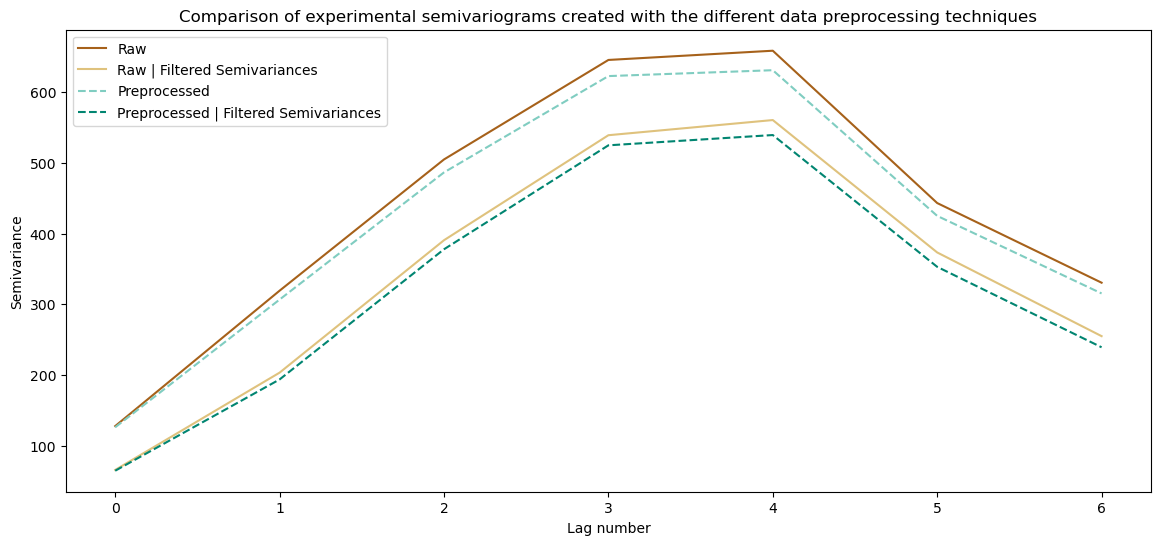

In [20]:
plt.figure(figsize=(14, 6))
plt.plot(raw_semivar[:, 1], c='#a6611a')
plt.plot(raw_semivar_not_out[:, 1], c='#dfc27d')
plt.plot(prep_semivar[:, 1], '--', c='#80cdc1')
plt.plot(prep_semivar_not_out[:, 1], '--', c='#018571')
plt.title('Comparison of experimental semivariograms created with the different data preprocessing techniques')
plt.ylabel('Semivariance')
plt.xlabel('Lag number')
plt.legend(['Raw', 'Raw | Filtered Semivariances', 'Preprocessed', 'Preprocessed | Filtered Semivariances'])
plt.show()

**Clarification:** An understanding of those plots is not an easy task. Let's divide reasoning into multiple points:

- Raw dataset and preprocessed raw dataset show a similar pattern. The differences are more pronounced for the distant lags than for the closest point pairs,
- Datasets with the cleaned variograms are different from the raw data. The absolute semivariance values per lag are smaller, and the semivariogram pattern is slightly different. Interestingly, the possible two distributions within the dataset are more visible in the cleaned variograms (one distribution with a peak around the 6th lag and the other with a peak around the 13th lag).
- The differences between semivariograms are mostly visible at larger distances, and differences are minor for the closest point pairs.
- **Filtering semivariance** sharply lowers the weights per lag, and **removing outliers** from the input data only slightly corrects variogram.

Let's check how different variograms work with real-world data.

## 5) Create Four Ordinary Kriging models based on the four Variogram Point Clouds and compare their performance

In [21]:
# Fit different semivariogram models into prepared datasets and variograms

# Raw
raw_theo = TheoreticalVariogram()
raw_theo.autofit(experimental_variogram=raw_semivar, return_params=False, nugget=0)

# Raw with cleaned variogram
raw_theo_no_out = TheoreticalVariogram()
raw_theo_no_out.autofit(experimental_variogram=raw_semivar_not_out, return_params=False, nugget=0)

# Preprocessed
prep_theo = TheoreticalVariogram()
prep_theo.autofit(experimental_variogram=prep_semivar, return_params=False, nugget=0)

# Preprocessed with cleaned variogram
prep_theo_no_out = TheoreticalVariogram()
prep_theo_no_out.autofit(experimental_variogram=prep_semivar_not_out, return_params=False, nugget=0)

/Users/szymonos/Documents/GitHub/pyinterpolate/pyinterpolate/variogram/theoretical/semivariogram.py:503: UserWarning: If you provide experimental variogram as a numpy array you must remember that the direction parameter must be set if it is a directional variogram. Otherwise, algorithm assumes that variogram is isotropic.
  warnings.warn(msg)


In [22]:
# Set Kriging models

# Raw
raw_model = kriging(observations=train, theoretical_model=raw_theo, points=test[:, :-1], allow_approx_solutions=True)

# Raw & cleaned
c_raw_model = kriging(observations=train, theoretical_model=raw_theo_no_out, points=test[:, :-1], allow_approx_solutions=True)

# Preprocessed
prep_model = kriging(observations=train, theoretical_model=prep_theo, points=test[:, :-1], allow_approx_solutions=True)

# Preprocessed & cleaned
c_prep_model = kriging(observations=train, theoretical_model=prep_theo_no_out, points=test[:, :-1], allow_approx_solutions=True)

  0%|          | 0/6204 [00:00<?, ?it/s]/Users/szymonos/Documents/GitHub/pyinterpolate/pyinterpolate/kriging/utils/process.py:124: UserWarning: 'Kriging system solution is based on the approximate solution, output may be incorrect!'
  warnings.warn(LeastSquaresApproximationWarning().__str__())
100%|██████████| 6204/6204 [00:01<00:00, 4904.78it/s]


In [23]:
# Build test function

def calculate_model_deviation(modeled_values, test_set):
    mse = ((test_set[:, -1] - modeled_values[:, 0])**2)
    return mse

In [24]:
r_test = calculate_model_deviation(raw_model, test)

In [25]:
cr_test = calculate_model_deviation(c_raw_model, test)

In [26]:
p_test = calculate_model_deviation(prep_model, test)

In [27]:
cp_test = calculate_model_deviation(c_prep_model, test)

In [28]:
df = pd.DataFrame(data=np.array([r_test, cr_test, p_test, cp_test]).transpose(),
                  columns=['Raw', 'Raw-cleaned', 'Preprocessed', 'Preprocessed-cleaned'])

We will use `.describe()` method from **pandas** to get the errors statistic:

In [29]:
df.describe()

,Raw,Raw-cleaned,Preprocessed,Preprocessed-cleaned
count,6.204000e+03,6.204000e+03,6.204000e+03,6.204000e+03
mean,1.099260e+03,1.311561e+03,1.360142e+03,9.300100e+02
std,3.262665e+04,2.594364e+04,5.314786e+04,2.063475e+04
min,6.117991e-08,4.858948e-07,2.577574e-09,1.054114e-08
25%,1.134439e+00,1.025883e+00,1.167352e+00,9.743158e-01
50%,8.933439e+00,8.406190e+00,9.354734e+00,8.053831e+00
75%,6.861941e+01,6.152264e+01,7.078416e+01,5.454659e+01
max,2.061752e+06,1.057215e+06,4.094596e+06,1.386895e+06


The view of this table may be different each time you run this tutorial (and it is related to the training-test division process). For some cases, you may get better results for the cleaned dataset; for others, results will be better for raw data. That's why we should always have a validation set to compare different scenarios. The other idea is to use all of the models and create a distribution of predictions and errors per point - we can use it later for decisions.

> **NOTE:** The example in this tutorial is related to the Digital Elevation Model, which the data provider preprocessed (*Copernicus Land Monitoring Services*). You shouldn't get the impression that raw data preprocessing and filtering are not required for the analysis. There are cases where the sensor may produce unreliable and biased results, such as a satellite camera's saturated pixel. It is better to remove it with the specific noise-filtering algorithm before the variogram point cloud development.

---